# Kaggle에서 서버로 데이터 다운

#### !pip install kaggle
#### kaggle datasets download kmader/skin-cancer-mnist-ham10000 -p HAM10000 --unzip

## 필요 라이브러리 설치
```
pip install pandas torch torchvision pillow matplotlib numpy
```

## 📌 4 - Reading & Processing data

In [1]:
import os
import pandas as pd

base_skin_dir = "../HAM10000/data"
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [2]:
# Data Cleaning
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [3]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

/tmp/ipykernel_3388964/4228450356.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [4]:
skin_df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

## 📌 5 - EDA

In [5]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: xlabel='dx_type'>

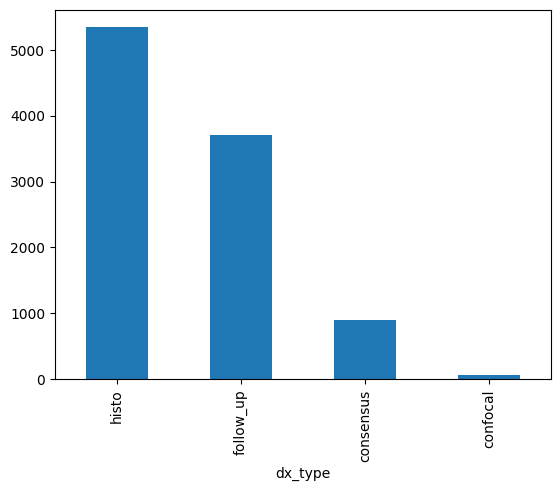

In [6]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<Axes: >

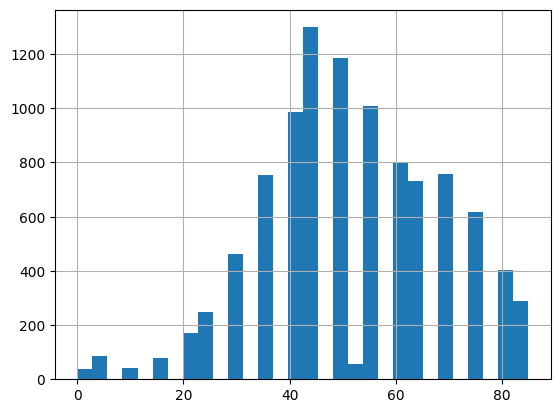

In [7]:
skin_df['age'].hist(bins=30)

<Axes: xlabel='sex'>

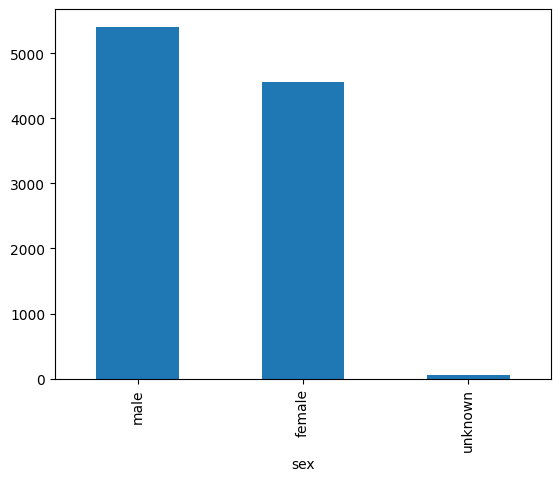

In [8]:
skin_df['sex'].value_counts().plot(kind='bar')

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models


if torch.cuda.is_available() and torch.cuda.device_count() > 3:
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")

# 데이터 전처리
# 학습 데이터에 대한 transform (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 검증 및 테스트 데이터에 대한 transform (증강 제외)
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# HAM10000 클래스 이름 매핑
class_names = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

# HAM10000 데이터셋 클래스
class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dirs = img_dirs  # 이미지 폴더 리스트
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(class_names.keys())}  # 라벨을 숫자로 매핑

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id'] + ".jpg"
        
        # 두 개의 폴더 중에서 이미지 찾기
        img_path = None
        for img_dir in self.img_dirs:
            path = os.path.join(img_dir, img_name)
            if os.path.exists(path):
                img_path = path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Image {img_name} not found in provided directories.")

        image = Image.open(img_path).convert("RGB")  # RGB 변환
        label = self.label_mapping[self.data.iloc[idx]['dx']]  # 올바른 라벨 가져오기

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋 로드 (올바른 이미지 폴더 경로 지정)
image_folders = ["../HAM10000/data/ham10000_images_part_1", "../HAM10000/data/ham10000_images_part_2", "../HAM10000/data/HAM10000_images_part_1", "../HAM10000/data/HAM10000_images_part_1"]
csv_file = "../HAM10000/data/HAM10000_metadata.csv"

dataset = HAM10000Dataset(csv_file=csv_file, img_dirs=image_folders, transform=train_transform)



# 전체 데이터셋 크기
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

print(f"Total samples: {total_size}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_data)}")


Total samples: 10015
Number of training samples: 8012
Number of validation samples: 1001
Number of test samples: 1002


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30, scheduler=None):
    model = model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []

    for epoch in range(num_epochs):
        # Training 단계
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation 단계
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        
        val_accuracies.append(epoch_accuracy)
        val_precisions.append(epoch_precision)
        val_recalls.append(epoch_recall)
        
        if scheduler:
            scheduler.step(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Acc: {epoch_accuracy*100:.2f}% | Prec: {epoch_precision:.4f} | Recall: {epoch_recall:.4f}")
    
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracy': val_accuracies,
        'precision': val_precisions,
        'recall': val_recalls,
    }
    return metrics


In [11]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss = running_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    return test_loss, accuracy, precision, recall


In [12]:
def plot_metrics(metrics, model_name):
    """
    에포크별 train/validation loss, Accuracy, Precision, Recall를 그래프로 시각화합니다.
    """
    epochs = np.arange(1, len(metrics['train_losses']) + 1)
    plt.figure(figsize=(12,10))

    # Loss 그래프
    plt.subplot(2,2,1)
    plt.plot(epochs, metrics['train_losses'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['val_losses'], label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(2,2,2)
    plt.plot(epochs, metrics['accuracy'], label='Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    # Precision 그래프
    plt.subplot(2,2,3)
    plt.plot(epochs, metrics['precision'], label='Precision', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision')
    plt.legend()

    # Recall 그래프
    plt.subplot(2,2,4)
    plt.plot(epochs, metrics['recall'], label='Recall', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(f'{model_name} Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
# 모델 생성
num_classes = len(class_names)

# ResNet18
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

# DenseNet121
model_densenet121 = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model_densenet121.classifier.in_features
model_densenet121.classifier = nn.Linear(num_ftrs, num_classes)

# MobileNetV2
model_mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_ftrs = model_mobilenet_v2.classifier[1].in_features
model_mobilenet_v2.classifier[1] = nn.Linear(num_ftrs, num_classes)

# EfficientNet-B0
model_efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_ftrs = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Vision Transformer (ViT-B/16)
'''
model_vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
num_ftrs = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(num_ftrs, num_classes)
'''
# 모델들을 딕셔너리에 저장
models_dict = {
    "ResNet18": model_resnet18,
    "DenseNet121": model_densenet121,
    "MobileNetV2": model_mobilenet_v2,
    "EfficientNetB0": model_efficientnet,
  #  "ViT-B16": model_vit
}



Training ResNet18 ...
Epoch 1/30 | Train Loss: 0.9432 | Val Loss: 0.7472 | Acc: 70.73% | Prec: 0.7049 | Recall: 0.7073
Epoch 2/30 | Train Loss: 0.7412 | Val Loss: 0.7115 | Acc: 74.33% | Prec: 0.7114 | Recall: 0.7433
Epoch 3/30 | Train Loss: 0.6837 | Val Loss: 0.7864 | Acc: 73.73% | Prec: 0.7252 | Recall: 0.7373
Epoch 4/30 | Train Loss: 0.6580 | Val Loss: 0.7089 | Acc: 73.13% | Prec: 0.7033 | Recall: 0.7313
Epoch 5/30 | Train Loss: 0.6335 | Val Loss: 0.6591 | Acc: 76.62% | Prec: 0.7526 | Recall: 0.7662
Epoch 6/30 | Train Loss: 0.6278 | Val Loss: 0.8625 | Acc: 66.73% | Prec: 0.7782 | Recall: 0.6673
Epoch 7/30 | Train Loss: 0.5910 | Val Loss: 0.6420 | Acc: 78.02% | Prec: 0.7725 | Recall: 0.7802
Epoch 8/30 | Train Loss: 0.5959 | Val Loss: 0.6553 | Acc: 77.02% | Prec: 0.7302 | Recall: 0.7702
Epoch 9/30 | Train Loss: 0.5761 | Val Loss: 0.6892 | Acc: 75.02% | Prec: 0.7379 | Recall: 0.7502
Epoch 10/30 | Train Loss: 0.5584 | Val Loss: 0.6940 | Acc: 75.92% | Prec: 0.7699 | Recall: 0.7592
Epoch 

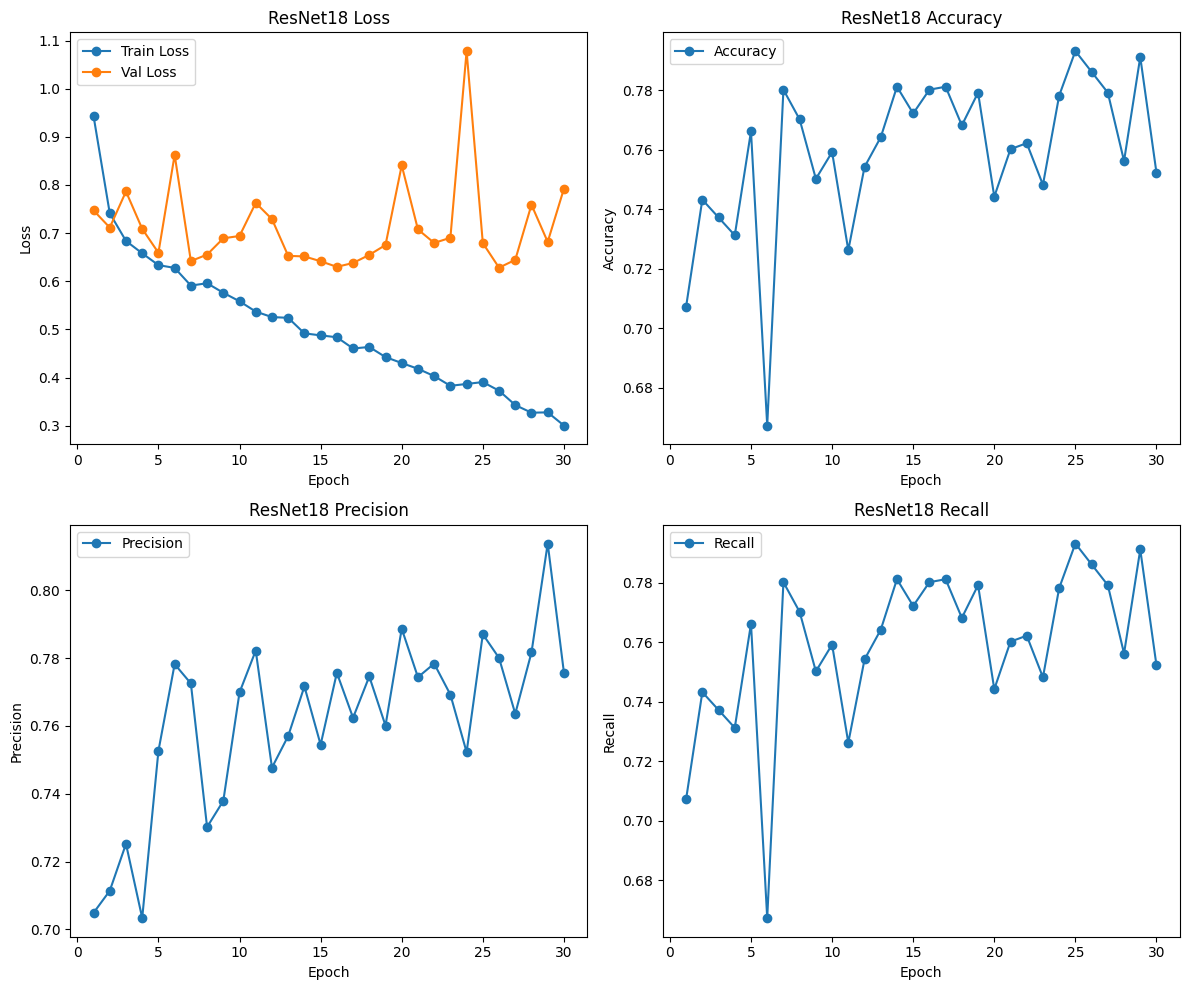

ResNet18 Test Metrics: Loss: 0.7818, Accuracy: 74.65%, Precision: 0.7687, Recall: 0.7465

Training DenseNet121 ...
Epoch 1/30 | Train Loss: 0.8946 | Val Loss: 0.8471 | Acc: 68.43% | Prec: 0.7408 | Recall: 0.6843
Epoch 2/30 | Train Loss: 0.7089 | Val Loss: 0.6773 | Acc: 74.13% | Prec: 0.7008 | Recall: 0.7413
Epoch 3/30 | Train Loss: 0.6621 | Val Loss: 0.6557 | Acc: 75.62% | Prec: 0.7165 | Recall: 0.7562
Epoch 4/30 | Train Loss: 0.6230 | Val Loss: 0.6590 | Acc: 75.62% | Prec: 0.7525 | Recall: 0.7562
Epoch 5/30 | Train Loss: 0.6106 | Val Loss: 0.6410 | Acc: 75.62% | Prec: 0.7714 | Recall: 0.7562
Epoch 6/30 | Train Loss: 0.5676 | Val Loss: 0.6677 | Acc: 76.12% | Prec: 0.7618 | Recall: 0.7612
Epoch 7/30 | Train Loss: 0.5565 | Val Loss: 0.6511 | Acc: 75.72% | Prec: 0.7570 | Recall: 0.7572
Epoch 8/30 | Train Loss: 0.5563 | Val Loss: 0.7259 | Acc: 75.42% | Prec: 0.7593 | Recall: 0.7542
Epoch 9/30 | Train Loss: 0.5266 | Val Loss: 0.6189 | Acc: 77.12% | Prec: 0.7772 | Recall: 0.7712
Epoch 10/30 

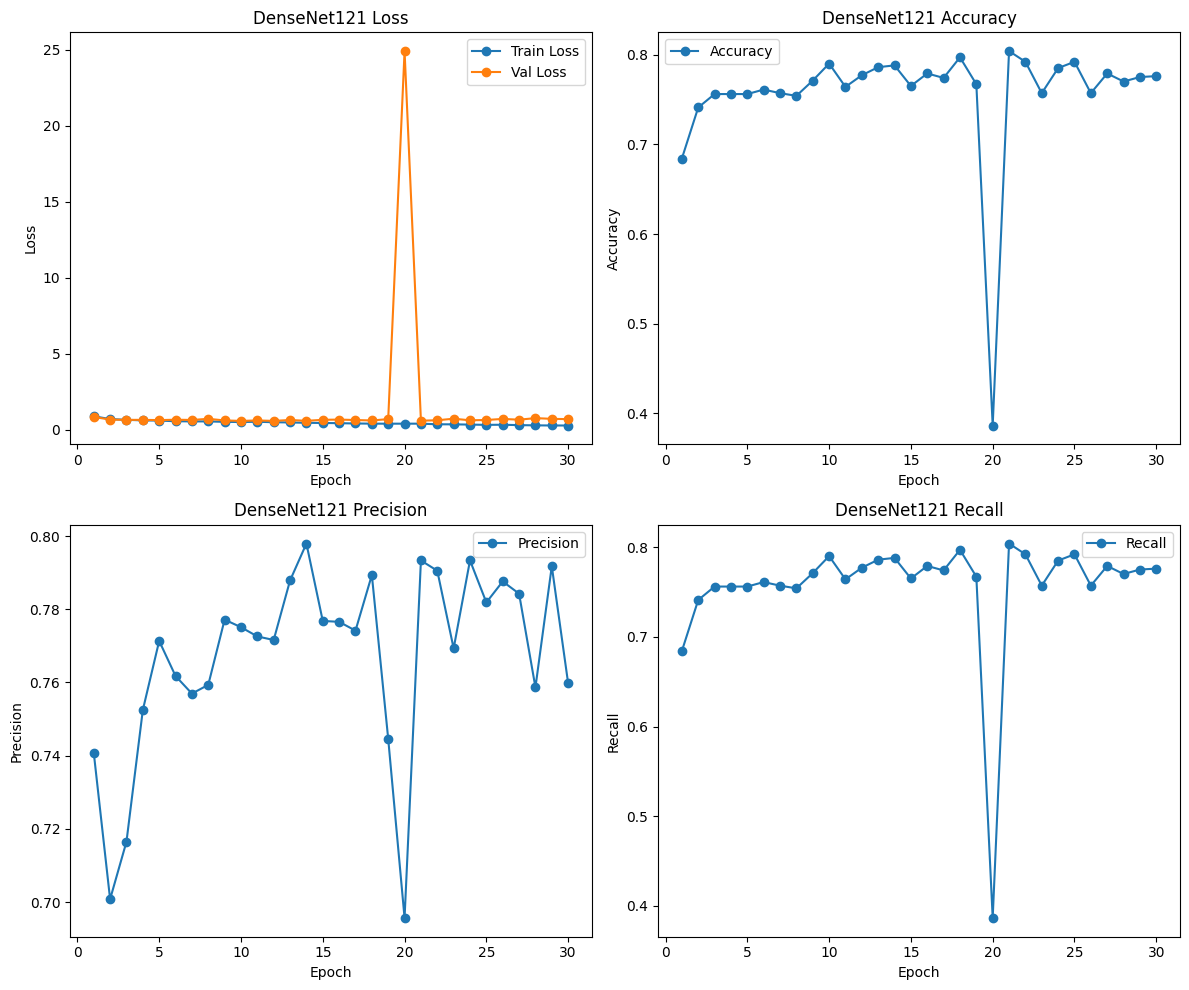

DenseNet121 Test Metrics: Loss: 0.6482, Accuracy: 80.24%, Precision: 0.7850, Recall: 0.8024

Training MobileNetV2 ...
Epoch 1/30 | Train Loss: 0.9324 | Val Loss: 0.7621 | Acc: 72.93% | Prec: 0.6921 | Recall: 0.7293
Epoch 2/30 | Train Loss: 0.7154 | Val Loss: 0.6830 | Acc: 75.62% | Prec: 0.7368 | Recall: 0.7562
Epoch 3/30 | Train Loss: 0.6476 | Val Loss: 0.6554 | Acc: 76.12% | Prec: 0.7413 | Recall: 0.7612
Epoch 4/30 | Train Loss: 0.6038 | Val Loss: 0.6291 | Acc: 76.52% | Prec: 0.7567 | Recall: 0.7652
Epoch 5/30 | Train Loss: 0.5833 | Val Loss: 0.6287 | Acc: 77.62% | Prec: 0.7713 | Recall: 0.7762
Epoch 6/30 | Train Loss: 0.5482 | Val Loss: 0.6191 | Acc: 79.32% | Prec: 0.7768 | Recall: 0.7932
Epoch 7/30 | Train Loss: 0.5377 | Val Loss: 0.6189 | Acc: 78.62% | Prec: 0.7724 | Recall: 0.7862
Epoch 8/30 | Train Loss: 0.4948 | Val Loss: 0.6521 | Acc: 75.82% | Prec: 0.7316 | Recall: 0.7582
Epoch 9/30 | Train Loss: 0.4874 | Val Loss: 0.6511 | Acc: 76.52% | Prec: 0.7694 | Recall: 0.7652
Epoch 10/

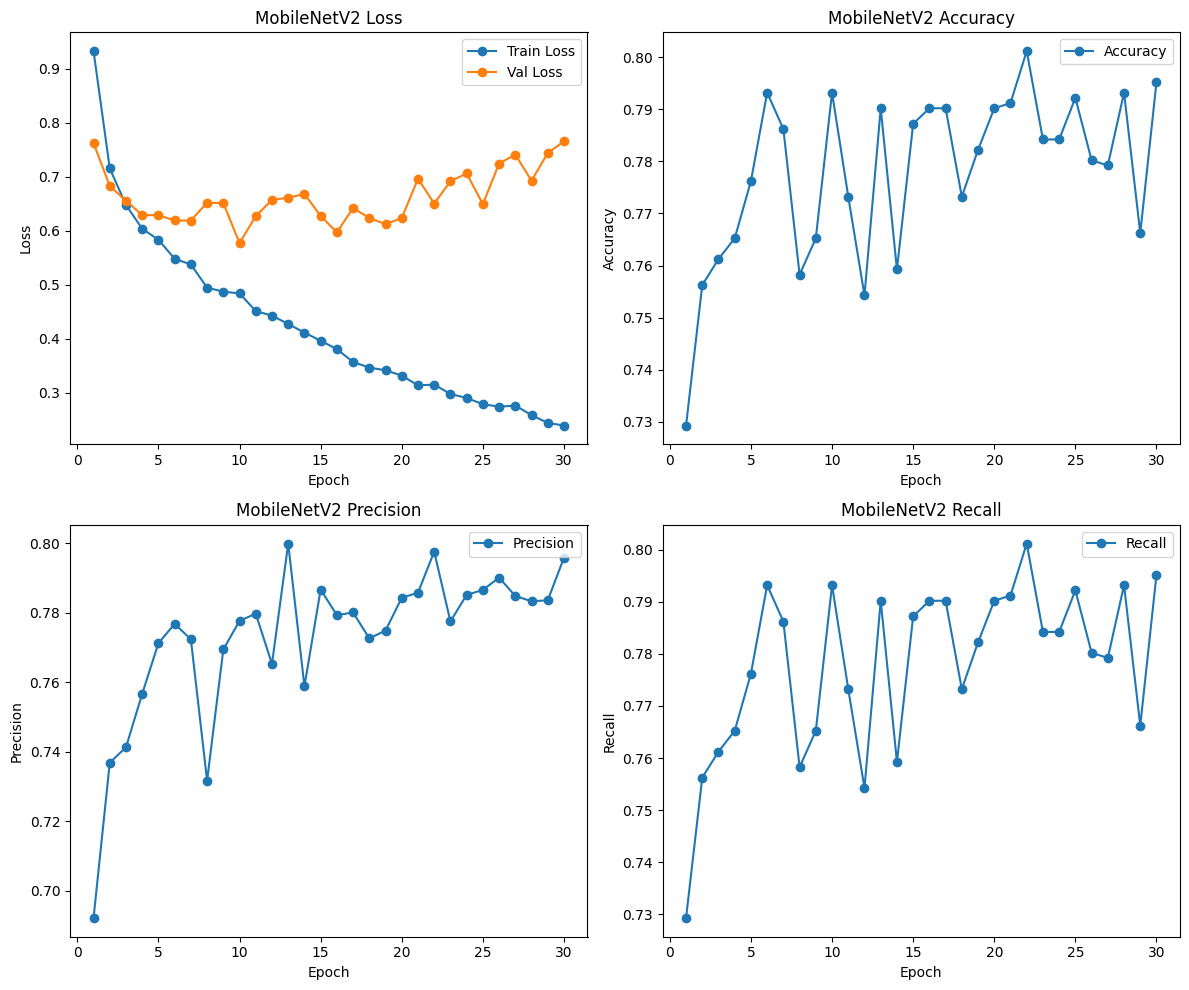

MobileNetV2 Test Metrics: Loss: 0.7103, Accuracy: 80.34%, Precision: 0.8006, Recall: 0.8034

Training EfficientNetB0 ...
Epoch 1/30 | Train Loss: 1.0216 | Val Loss: 0.8516 | Acc: 70.43% | Prec: 0.6794 | Recall: 0.7043
Epoch 2/30 | Train Loss: 0.7959 | Val Loss: 0.7388 | Acc: 75.12% | Prec: 0.7290 | Recall: 0.7512
Epoch 3/30 | Train Loss: 0.7122 | Val Loss: 0.7185 | Acc: 75.12% | Prec: 0.7172 | Recall: 0.7512
Epoch 4/30 | Train Loss: 0.6380 | Val Loss: 0.6871 | Acc: 76.52% | Prec: 0.7467 | Recall: 0.7652
Epoch 5/30 | Train Loss: 0.5988 | Val Loss: 0.6407 | Acc: 76.52% | Prec: 0.7568 | Recall: 0.7652
Epoch 6/30 | Train Loss: 0.5692 | Val Loss: 0.6401 | Acc: 75.32% | Prec: 0.7774 | Recall: 0.7532
Epoch 7/30 | Train Loss: 0.5358 | Val Loss: 0.6270 | Acc: 78.12% | Prec: 0.7668 | Recall: 0.7812
Epoch 8/30 | Train Loss: 0.5170 | Val Loss: 0.6298 | Acc: 75.92% | Prec: 0.7672 | Recall: 0.7592
Epoch 9/30 | Train Loss: 0.4915 | Val Loss: 0.6417 | Acc: 75.92% | Prec: 0.7475 | Recall: 0.7592
Epoch 

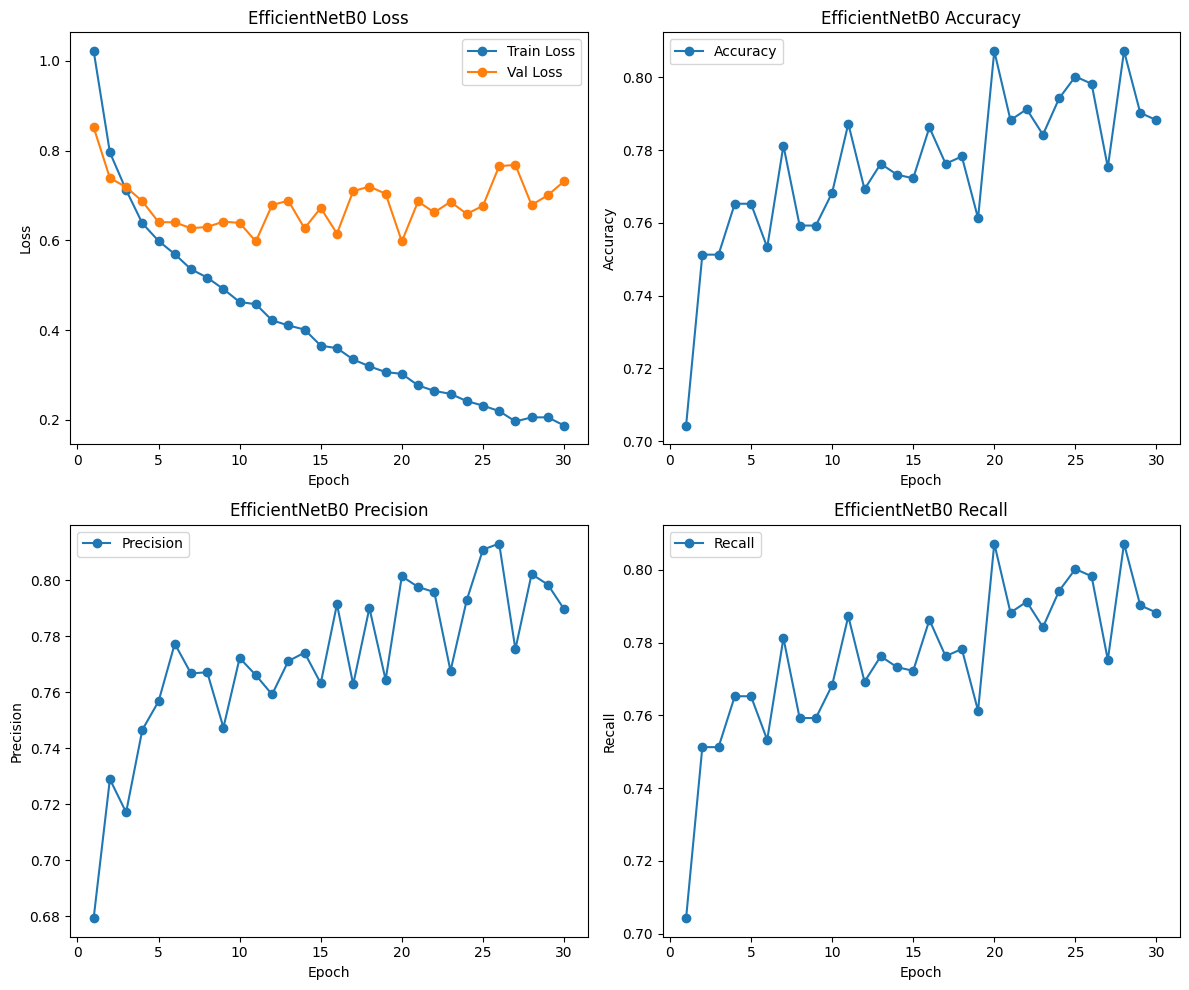

EfficientNetB0 Test Metrics: Loss: 0.7099, Accuracy: 81.04%, Precision: 0.8023, Recall: 0.8104

 최종결과
ResNet18: Loss: 0.7818, Accuracy: 74.65%, Precision: 0.7687, Recall: 0.7465
DenseNet121: Loss: 0.6482, Accuracy: 80.24%, Precision: 0.7850, Recall: 0.8024
MobileNetV2: Loss: 0.7103, Accuracy: 80.34%, Precision: 0.8006, Recall: 0.8034
EfficientNetB0: Loss: 0.7099, Accuracy: 81.04%, Precision: 0.8023, Recall: 0.8104


In [14]:
criterion = nn.CrossEntropyLoss()
num_epochs = 30
results = {}  # 각 모델의 최종 테스트 성능 저장

for model_name, model in models_dict.items():
    print("\n==========================================")
    print(f"Training {model_name} ...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    metrics = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)
    plot_metrics(metrics, model_name)
    
    # 테스트 셋에서 평가
    test_loss, test_acc, test_prec, test_rec = evaluate_model(model, test_loader, criterion, device)
    results[model_name] = {
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "test_precision": test_prec,
        "test_recall": test_rec,
    }
    print(f"{model_name} Test Metrics: Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%, "
          f"Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")
    
# 최종결과
print("\n 최종결과")
for model_name, metrics in results.items():
    print(f"{model_name}: Loss: {metrics['test_loss']:.4f}, "
          f"Accuracy: {metrics['test_accuracy']*100:.2f}%, "
          f"Precision: {metrics['test_precision']:.4f}, "
          f"Recall: {metrics['test_recall']:.4f}")

In [15]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 3 x 64 x 64 -> 32 x 64 x 64 -> 32 x 64 x 64, then MaxPool -> 32 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2: 32 x 32 x 32 -> 64 x 32 x 32 -> 64 x 32 x 32, then MaxPool -> 64 x 16 x 16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3: 64 x 16 x 16 -> 128 x 16 x 16 -> 128 x 16 x 16, then MaxPool -> 128 x 8 x 8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

num_classes = len(class_names)
model_cnn = CustomCNN(num_classes=num_classes)
print(model_cnn)

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128


 CNN 모델


/home/mini/miniconda3/envs/mini/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 1.4458 | Val Loss: 0.9884 | Acc: 68.13% | Prec: 0.4658 | Recall: 0.6813
Epoch 2/30 | Train Loss: 1.0017 | Val Loss: 0.8898 | Acc: 69.83% | Prec: 0.5336 | Recall: 0.6983
Epoch 3/30 | Train Loss: 0.9520 | Val Loss: 0.8773 | Acc: 68.43% | Prec: 0.5942 | Recall: 0.6843
Epoch 4/30 | Train Loss: 0.9104 | Val Loss: 0.8468 | Acc: 70.13% | Prec: 0.5877 | Recall: 0.7013
Epoch 5/30 | Train Loss: 0.8831 | Val Loss: 0.8249 | Acc: 69.93% | Prec: 0.6860 | Recall: 0.6993
Epoch 6/30 | Train Loss: 0.8645 | Val Loss: 0.7951 | Acc: 70.63% | Prec: 0.6099 | Recall: 0.7063
Epoch 7/30 | Train Loss: 0.8559 | Val Loss: 0.9068 | Acc: 70.63% | Prec: 0.6369 | Recall: 0.7063
Epoch 8/30 | Train Loss: 0.8316 | Val Loss: 0.7941 | Acc: 70.73% | Prec: 0.5821 | Recall: 0.7073
Epoch 9/30 | Train Loss: 0.8404 | Val Loss: 0.7655 | Acc: 72.73% | Prec: 0.6667 | Recall: 0.7273
Epoch 10/30 | Train Loss: 0.8277 | Val Loss: 0.7456 | Acc: 72.73% | Prec: 0.7023 | Recall: 0.7273
Epoch 11/30 | Train Loss: 0.8

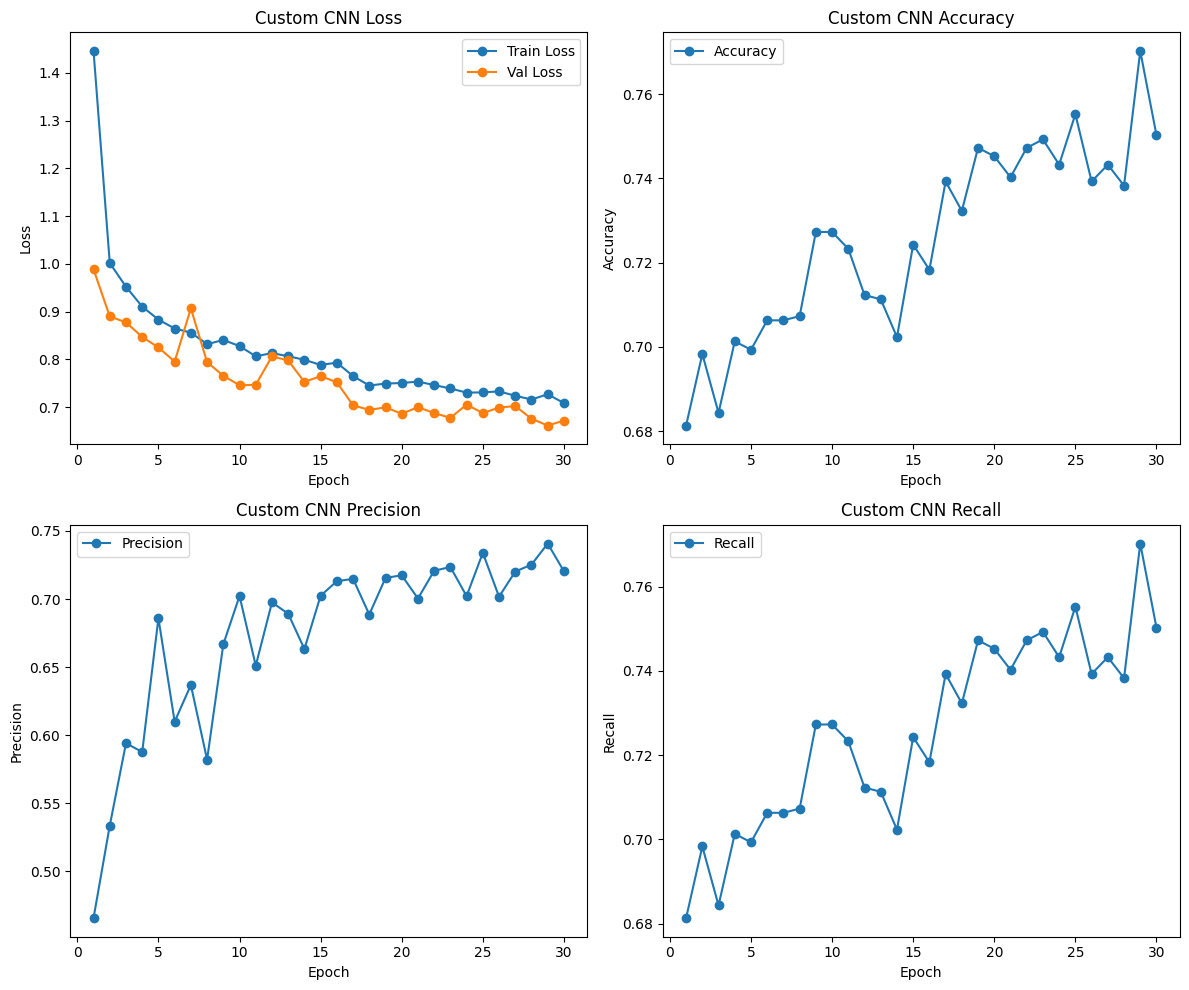


최종결과 : 
 Loss: 0.6888
 Accuracy: 75.45%
 Precision: 0.7254
 Recall: 0.7545


In [16]:
criterion = nn.CrossEntropyLoss()
# weight_decay로 정규화 효과 적용
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.5, patience=5, verbose=True)

num_epochs = 30

print("\n CNN 모델")
metrics_cnn = train_model(model_cnn, train_loader, val_loader, criterion, optimizer_cnn, device, num_epochs, scheduler=scheduler)
plot_metrics(metrics_cnn, "Custom CNN")

# 테스트 셋에서 최종 평가
test_loss, test_acc, test_prec, test_rec = evaluate_model(model_cnn, test_loader, criterion, device)
print(f"\n최종결과 : \n Loss: {test_loss:.4f}\n Accuracy: {test_acc*100:.2f}%\n Precision: {test_prec:.4f}\n Recall: {test_rec:.4f}")
